In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
# Load the dataset (replace 'your_file.csv' with actual file path)
df = pd.read_csv("housing_price_dataset.csv")

# Display the first few rows
print(df.head())

   SquareFeet  Bedrooms  Bathrooms Neighborhood  YearBuilt          Price
0        2126         4          1        Rural       1969  215355.283618
1        2459         3          2        Rural       1980  195014.221626
2        1860         2          1       Suburb       1970  306891.012076
3        2294         2          1        Urban       1996  206786.787153
4        2130         5          2       Suburb       2001  272436.239065


In [33]:
df.describe()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price
count,49978.000000,49978.000000,49978.000000,49978.000000,49978.000000
mean,2006.752551,3.498659,1.995458,1985.404338,224931.667960
std,575.350298,1.116325,0.815859,20.718407,75995.682992
min,1000.000000,2.000000,1.000000,1950.000000,154.779120
25%,1514.000000,3.000000,1.000000,1967.000000,170007.487130
50%,2008.000000,3.000000,2.000000,1985.000000,225100.123857
75%,2506.000000,4.000000,3.000000,2003.000000,279395.826288
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


In [23]:
# Remove rows where Price is negative
(df["Price"] < 0).sum()


0

In [22]:
# Remove rows where Price is negative
df = df[df["Price"] > 0]


In [24]:
# Step 1: Check for missing values
print(df.isnull().sum())

SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64


In [25]:
# Step 2: Encode categorical variables (Neighborhood)
df = pd.get_dummies(df, columns=["Neighborhood"], drop_first=True)

In [26]:
df.head()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price,Neighborhood_Suburb,Neighborhood_Urban
0,2126,4,1,1969,215355.283618,False,False
1,2459,3,2,1980,195014.221626,False,False
2,1860,2,1,1970,306891.012076,True,False
3,2294,2,1,1996,206786.787153,False,True
4,2130,5,2,2001,272436.239065,True,False


In [27]:
# Step 3: Split into features (X) and target variable (y)
X = df.drop(columns=["Price"])  # Features
y = df["Price"]  # Target variable

# Step 4: Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Step 5: Normalize numerical features (optional, useful for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# Step 6: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [30]:
# Step 7: Make predictions
y_pred = model.predict(X_test_scaled)

# Step 8: Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


In [31]:
print(f"Model Performance:\nRMSE: {rmse:.2f}\nR² Score: {r2:.2f}")

Model Performance:
RMSE: 52548.88
R² Score: 0.52


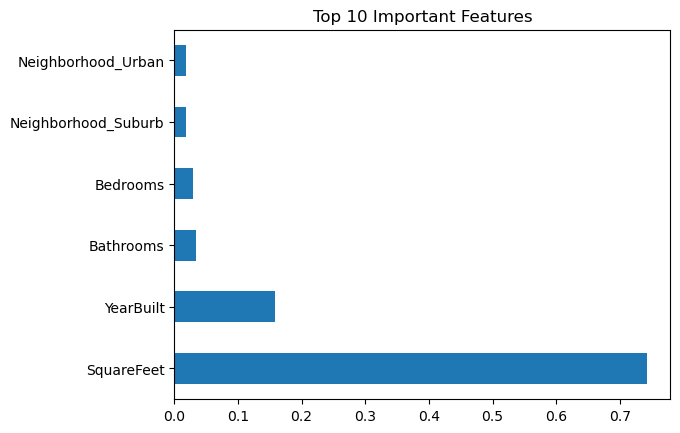

In [32]:
# Step 9: Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()

In [34]:
feature_importance

SquareFeet             0.742069
Bedrooms               0.029195
Bathrooms              0.033757
YearBuilt              0.157607
Neighborhood_Suburb    0.018893
Neighborhood_Urban     0.018478
dtype: float64

In [36]:
# Create interaction terms
df['SquareFeet_Bedrooms'] = df['SquareFeet'] * df['Bedrooms']
df['SquareFeet_Bathrooms'] = df['SquareFeet'] * df['Bathrooms']

# Create polynomial features
df['SquareFeet_squared'] = df['SquareFeet'] ** 2
df['YearBuilt_squared'] = df['YearBuilt'] ** 2

# Log transformation
df['Log_Price'] = np.log1p(df['Price'])
df['Log_SquareFeet'] = np.log1p(df['SquareFeet'])

# Binning YearBuilt
df['YearBuilt_Bin'] = pd.cut(df['YearBuilt'], bins=[1900, 1950, 1980, 2000, 2020], labels=[1, 2, 3, 4])

# Update X and y
X = df.drop(columns=["Price", "Log_Price"])
y = df["Log_Price"]  # Use log-transformed target variable

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
print(f"Training Features Shape: {X_train.shape}")


Training Features Shape: (39982, 12)


In [38]:
# Step 5: Normalize numerical features (optional, useful for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model with the best parameters
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Improved Model Performance:\nRMSE: {rmse:.2f}\nR² Score: {r2:.2f}")

Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Improved Model Performance:
RMSE: 0.29
R² Score: 0.51


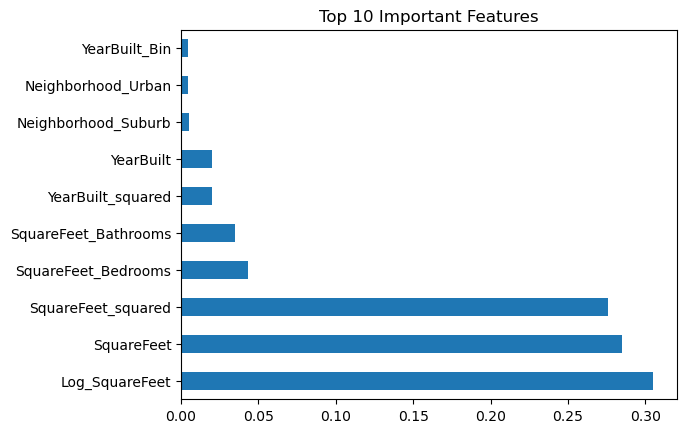

In [47]:
# Step 9: Feature Importance
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()

In [44]:
import joblib

# Save the model to a file
joblib.dump(best_model, 'housing_price_model.pkl')

['housing_price_model.pkl']

In [45]:
print(f"Training Features Shape: {X_train_scaled.shape}")


Training Features Shape: (39982, 12)
